# BTC-USD ENDEKSİ

In [1]:
# Veri okuma ve işleme adımında kullanılacak kütüphaneler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# !pip install tensorflow
import tensorflow as tf

# Model için kullanılacak kütüphaneler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model değerlendirme ve veri ölçeklendirmede kullanılacak kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Uyarıları kapatmak için kullanılacak kütüphaneler
import itertools
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
df = pd.read_csv("BTC-USD.csv").dropna()

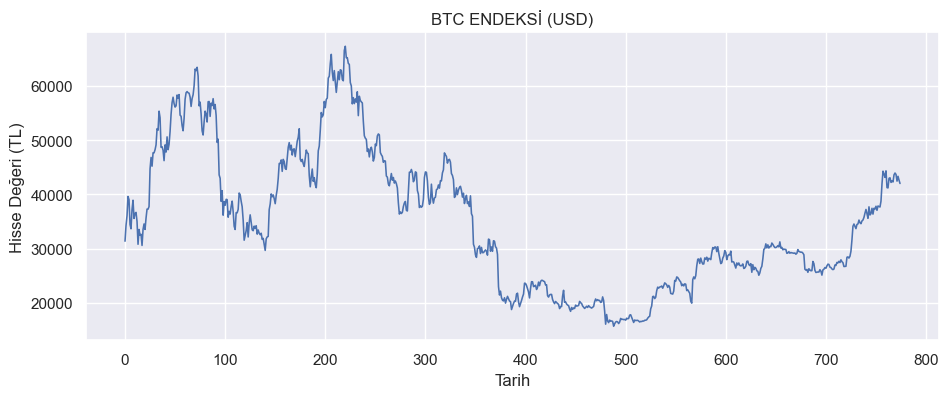

In [3]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = df["Close"].plot(linestyle='-', linewidth=1.15, label='Daily')
ax.set_ylabel("Hisse Değeri (TL)")
ax.set_xlabel("Tarih")
ax.set_title("BTC ENDEKSİ (USD)")
plt.show();

In [4]:
# Eğitim-Doğrulama-Test seti olarak bölelim
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)

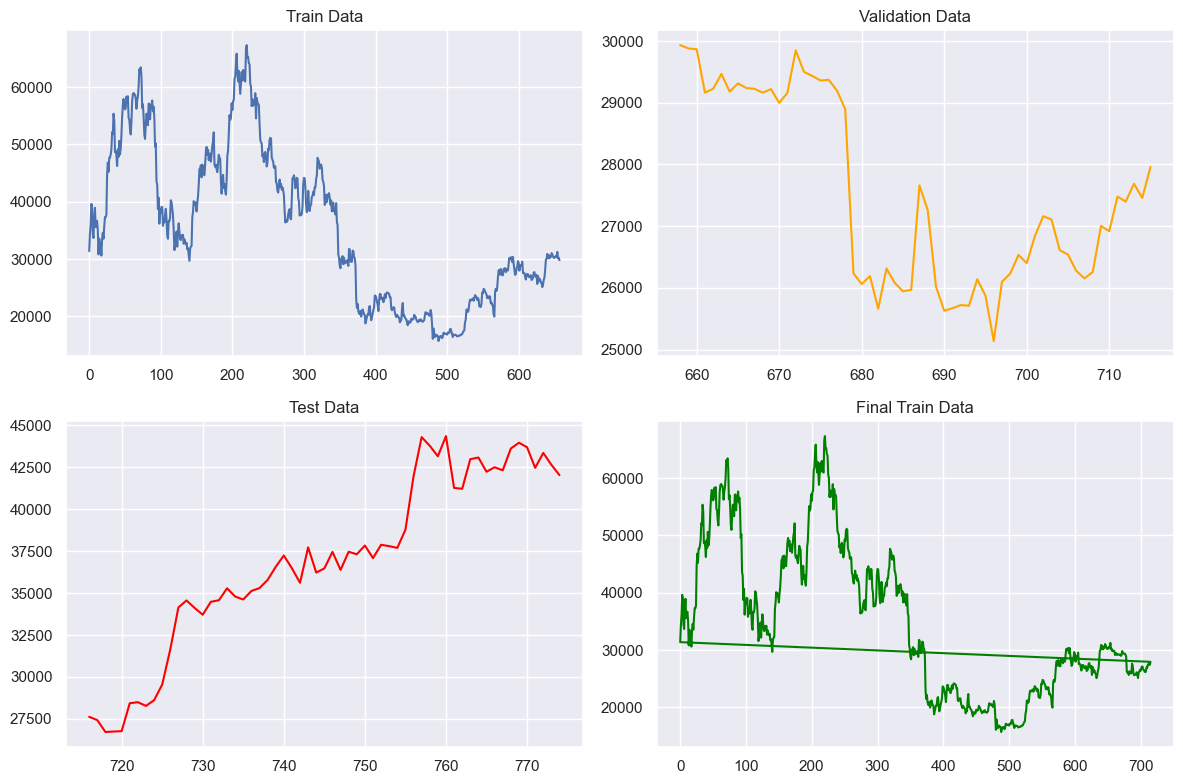

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
train.plot(ax=axes[0, 0], title="Train Data")
validation.plot(ax=axes[0, 1], title="Validation Data",color="orange")
test.plot(ax=axes[1, 0], title="Test Data",color="red")
final_train.plot(ax=axes[1, 1], title="Final Train Data",color="green")
plt.tight_layout()
plt.show();

# SES MODEL

## SES MODEL PARAMETRE OPTİMİZASYONU

In [6]:
index = df.shape[0]*0.8477
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
len(train), len(validation), len(test)
def ses_optimizer(train, alphas, step=len(validation)):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        validation_pred = ses_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae
alphas = np.arange(0.01, 1, 0.01)
best_alpha, best_mae = ses_optimizer(train, alphas, step=len(validation)) # best_alpha: 0.02 best_mae: 1385.1821

best_alpha: 0.02 best_mae: 1385.1821


### ONE STEP AHEAD METHOD(SES)

In [7]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
btc_ses_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = SimpleExpSmoothing(final_train).fit(smoothing_level=best_alpha)
    output = model_fit.forecast()
    yhat = output[0]
    btc_ses_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### SES MODEL HATASI

In [8]:
btc_ses_rmse = np.sqrt(mean_squared_error(test,btc_ses_model_predictions)) 
test = np.array(test)
btc_ses_model_predictions = np.array(btc_ses_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
btc_ses_mape = mape(test,btc_ses_model_predictions) # MAPE = 17.220025186484197
print(btc_ses_mape)

17.220025186484197


### SES MODELİN TAHMİN GRAFİĞİ:

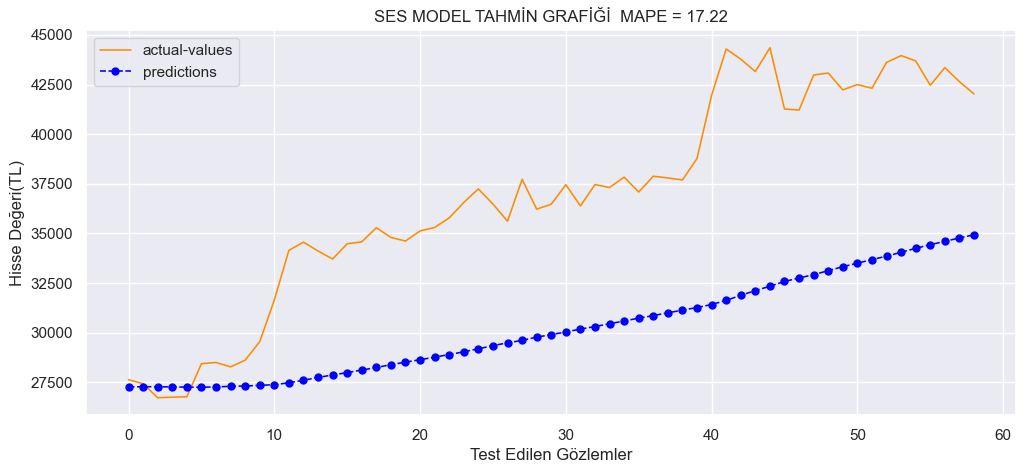

In [9]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(btc_ses_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Test Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("SES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(btc_ses_mape,3)))
plt.legend();

# DES MODEL

## DES MODEL PARAMETRE OPTİMİZASYONU

In [10]:
index = df.shape[0]*0.8477
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def des_optimizer(train, alphas, betas, step=len(validation)):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            validation_pred = des_model.forecast(step)
            mae = mean_absolute_error(validation, validation_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae
alphas = np.arange(0.01, 1, 0.01)
betas = np.arange(0.1, 1, 0.01)
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=len(validation))
# best_alpha: 0.21 best_beta: 0.49 best_mae: 861.4969

best_alpha: 0.21 best_beta: 0.49 best_mae: 861.4969


### ONE STEP AHEAD METHOD(DES)

In [11]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
btc_des_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
    output = model_fit.forecast()
    yhat = output[0]
    btc_des_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### DES MODEL HATASI

In [12]:
btc_des_rmse = np.sqrt(mean_squared_error(test,btc_des_model_predictions)) # RMSE = 10.320334750984863
test = np.array(test)
btc_des_model_predictions = np.array(btc_des_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
btc_des_mape = mape(test,btc_des_model_predictions)
print(btc_des_mape) # MAPE = 4.139064131983737

4.139064131983737


### DES MODEL TAHMİN GRAFİĞİ:

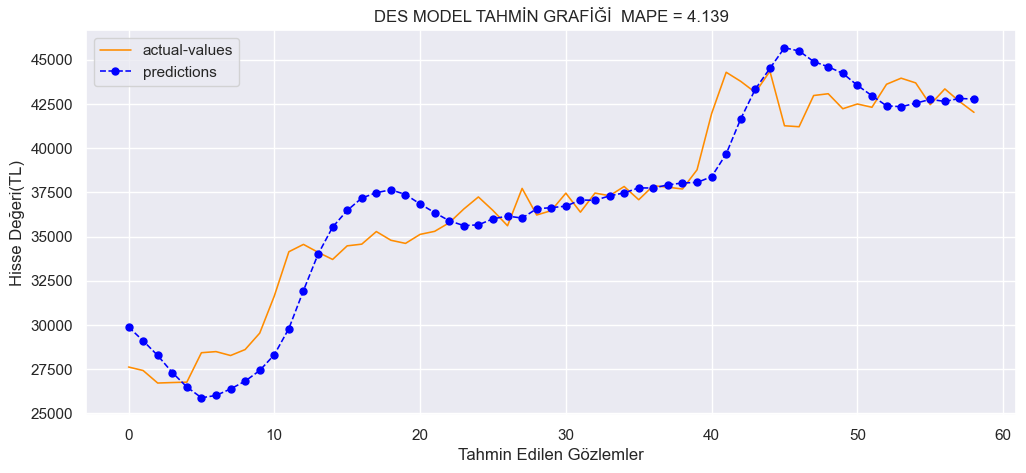

In [13]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(btc_des_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tahmin Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("DES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(btc_des_mape,3)))
plt.legend();

# TES MODEL

## TES PARAMETRE OPTİMİZASYONU

In [14]:
len(validation),len(test)

(60, 59)

In [15]:
index = df.shape[0]*(0.84774)
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def tes_optimizer(train, abg, step=len(validation)):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        validation_pred = tes_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae
alphas = betas = gammas = np.arange(0.01, 1, 0.1)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=len(validation))
#

best_alpha: 0.21 best_beta: 0.21 best_gamma: 0.51 best_mae: 935.5303


### ONE STEP AHEAD METHOD(TES)

In [16]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
btc_tes_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add", seasonal="add", seasonal_periods=5).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
    # model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    btc_tes_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### TES MODEL HATASI

In [17]:
btc_tes_rmse = np.sqrt(mean_squared_error(test,btc_tes_model_predictions)) # RMSE = 4.622969967001846
test = np.array(test)
btc_tes_model_predictions = np.array(btc_tes_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
btc_tes_mape = mape(test,btc_tes_model_predictions)
print(btc_tes_mape) # MAPE = 4.2527978653696135

4.2527978653696135


### TES MODEL TAHMİN GRAFİĞİ:

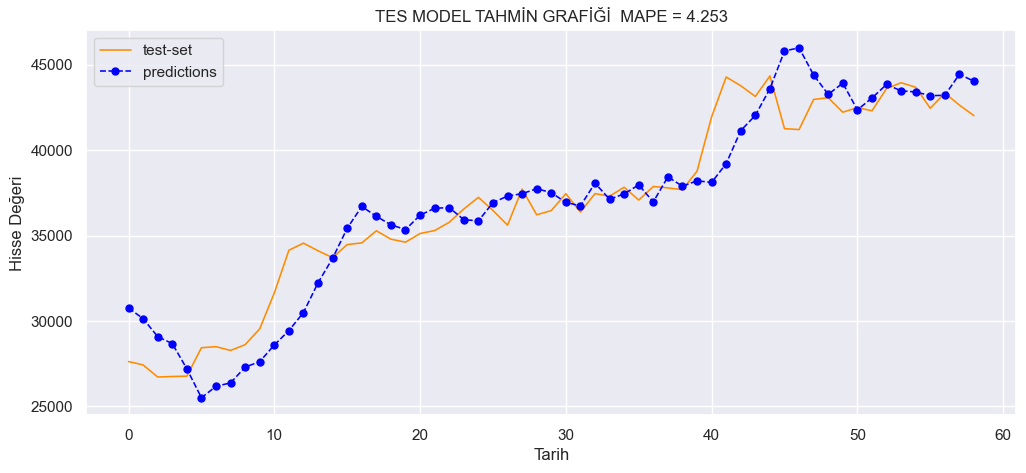

In [18]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(btc_tes_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("TES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(btc_tes_mape,3)))
plt.legend();

# ARIMA MODEL

## ARIMA MODEL PARAMETRE OPTMİZASYONU

In [19]:
index = df.shape[0]*0.8477
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model = sm.tsa.ARIMA(train, order=order).fit()
            aic = arima_model.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params
best_params_aic = arima_optimizer_aic(train, pdq)
# Best ARIMA(3, 1, 2) AIC=11451.62  <- parametreler.

Best ARIMA(3, 1, 2) AIC=11451.62


### ONE STEP AHEAD METHOD(ARIMA)

In [20]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
btc_arima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = sm.tsa.ARIMA(final_train, order=best_params_aic)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    btc_arima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### ARIMA MODEL HATASI

In [21]:
btc_arima_rmse = np.sqrt(mean_squared_error(test,btc_arima_model_predictions)) # RMSE = 3.1332348079593957
test = np.array(test)
btc_arima_model_predictions = np.array(btc_arima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
btc_arima_mape = mape(test,btc_arima_model_predictions) 
print(btc_arima_mape) # MAPE = 2.2813670435336606

2.2813670435336606


### ARIMA MODEL TAHMİN GRAFİĞİ:

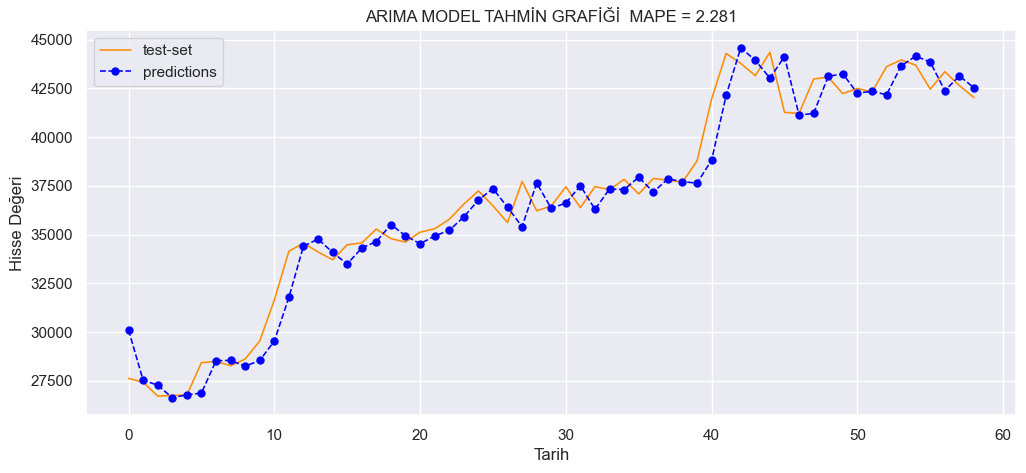

In [22]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(btc_arima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(btc_arima_mape,3)))
plt.legend();

# SARIMA MODEL

## SARIMA MODEL PARAMETRE OPTİMİZASYONU

In [23]:
index = df.shape[0]*0.8477
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)
# SARIMA(0, 1, 0)x(0, 1, 1, 5)12 - AIC:11450.971007330008 <- parametreler.

SARIMA(0, 1, 0)x(0, 1, 1, 5)12 - AIC:11450.971007330008


### ONE STEP AHEAD METHOD(SARIMA)

In [24]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
btc_sarima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = SARIMAX(final_train, order=best_order, seasonal_order=best_seasonal_order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    btc_sarima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### SARIMA MODEL HATASI

In [25]:
btc_sarima_rmse = np.sqrt(mean_squared_error(test,btc_sarima_model_predictions)) # RMSE = 3.13743723917444
test = np.array(test)
btc_sarima_model_predictions = np.array(btc_sarima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
btc_sarima_mape = mape(test,btc_sarima_model_predictions) # MAPE = 2.2684225707425907
print(btc_sarima_mape)

2.2684225707425907


### SARIMA MODEL TAHMİN GRAFİĞİ:

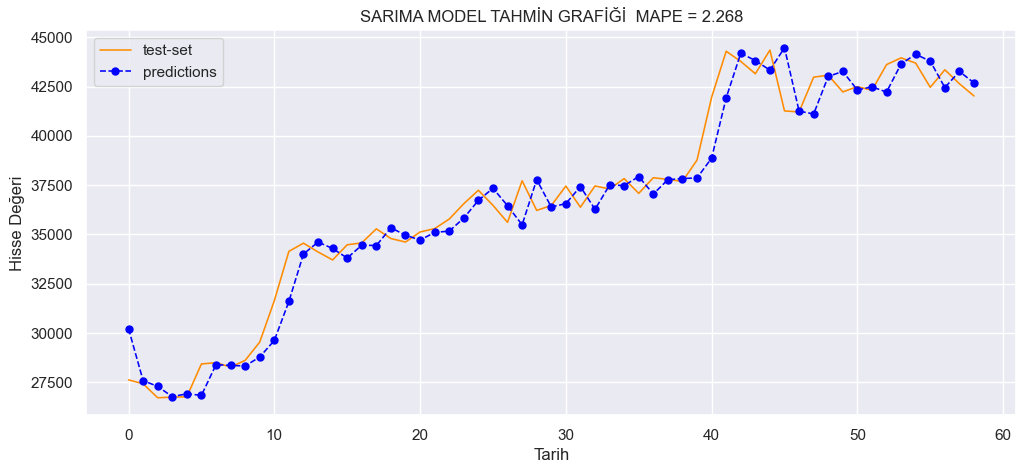

In [26]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(btc_sarima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("SARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(btc_sarima_mape,3)))
plt.legend();

# ANN MODEL(LSTM)

In [27]:
data = pd.read_csv("BTC-USD.csv")
prices = data['Close'].values

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

In [29]:
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
lookback = 30

In [30]:
train_size = int(len(prices_scaled) * 0.925) 
train_data = prices_scaled[:train_size]
test_data = prices_scaled[train_size - lookback:]  
train_size, len(train_data), len(test_data)

(716, 716, 89)

In [31]:
# Ayrı ayrı veri seti oluştur
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)
# LSTM için giriş verisini yeniden şekillendir
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [32]:
# Model oluştur
tf.random.set_seed(42)
model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, 1)),
    Dense(1)])
# Modeli derle
model.compile(optimizer='adam', loss='mse')
# Modeli eğit
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1367 - val_loss: 0.0079
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0064
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 12/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_lo

In [33]:
btc_ann_pred = model.predict(X_test)
# Veriyi orijinal ölçeğe geri çevir
y_pred_ann_inverse = scaler.inverse_transform(btc_ann_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, predictions):
    return np.mean(np.abs((actual - predictions) / actual)) * 100
btc_ann_mape = mape(y_test_inverse, y_pred_ann_inverse)
print(btc_ann_mape) # MAPE = 3.483379306223676

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4.202243456260125


In [34]:
test = np.array(y_test_inverse)
btc_ann_model_predictions = np.array(y_pred_ann_inverse)

### ANN MODEL TAHMİN GRAFİĞİ:

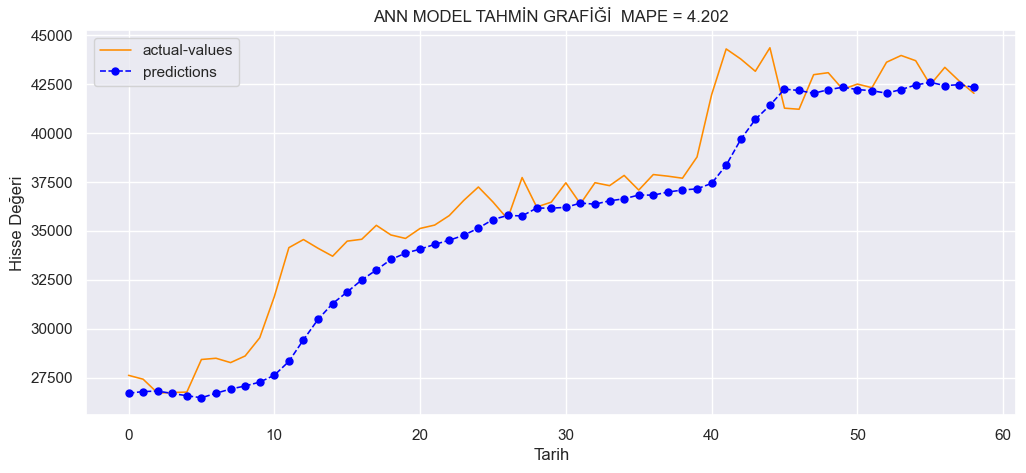

In [35]:
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(btc_ann_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ANN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(btc_ann_mape,3)))
plt.legend();

# CNN MODEL

In [36]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten

In [37]:
data = pd.read_csv("BTC-USD.csv")
prices = data["Close"].values

In [38]:
# Parametreler
lookback = 10
test_size = 59
# Veriyi böl (lookback'i unutma!)
train_prices = prices[:-(test_size)]
test_prices = prices[-(test_size + lookback):]  # Test için lookback öncesi veriler dahil edilir
# Ölçeklendirme (sadece train'e fit et)
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices_scaled = scaler.fit_transform(train_prices.reshape(-1, 1))
test_prices_scaled = scaler.transform(test_prices.reshape(-1, 1))

In [39]:
# Dataset oluşturma fonksiyonu
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
X_train, y_train = create_dataset(train_prices_scaled, lookback)
X_test, y_test = create_dataset(test_prices_scaled, lookback)

In [40]:
# CNN için reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [41]:
# Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
# Compile
model.compile(optimizer='adam', loss='mse')
# Eğitim
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test));

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0438 - val_loss: 0.0024
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.0029 - val_loss: 0.0025
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0017 - val_loss: 8.2880e-04
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - val_loss: 6.5463e-04
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.0013 - val_loss: 5.7955e-04
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.0011 - val_loss: 5.4093e-04
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.0011 - val_loss: 5.5109e-04
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 0.0010 - val_loss: 5.2589e-04
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - val_loss: 5.2837e-04
Epoch 12/20
45/45 ━━━━━━━━━━━━

In [42]:
y_pred_scaled = model.predict(X_test)
btc_cnn_y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100
btc_cnn_mape = mape(y_test_inverse, btc_cnn_y_pred)
print(f"Test MAPE: {btc_cnn_mape}") # Test MAPE: 2.336882540490728

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test MAPE: 2.3842282214382107


In [59]:
btc_cnn_rmse = np.sqrt(mean_squared_error(test,btc_cnn_y_pred)) # RMSE = 1170.614783254498
print(btc_cnn_rmse);

1170.614783254498


###  CNN MODEL TAHMİN GRAFİĞİ:

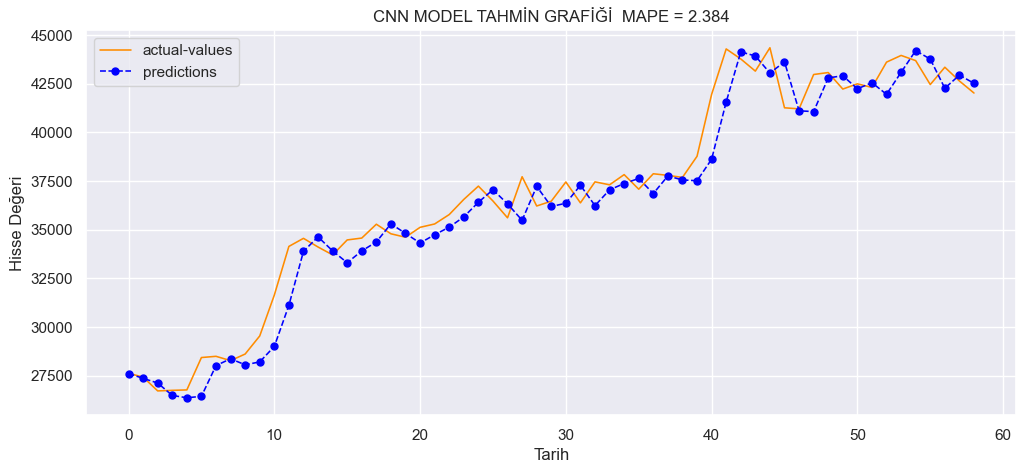

In [43]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(btc_cnn_y_pred,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("CNN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(btc_cnn_mape,3)))
plt.legend();

#

## KOMBİNASYON YÖNTEMİ VE BAŞARISI

## YÖNTEMLERİN MAPE DEĞERLERİ:

In [44]:
best_model = pd.DataFrame([btc_ses_mape, btc_des_mape, btc_tes_mape,
                           btc_arima_mape, btc_sarima_mape,
                           btc_ann_mape, btc_cnn_mape],

                          index=["SES MODEL", "DES MODEL", "TES MODEL", "ARIMA MODEL", "SARIMA MODEL","ANN MODEL","CNN MODEL"],

                          columns=["MAPE Değerleri"])
print(best_model.sort_values("MAPE Değerleri", ascending=True));

              MAPE Değerleri
SARIMA MODEL        2.268423
ARIMA MODEL         2.281367
CNN MODEL           2.384228
DES MODEL           4.139064
ANN MODEL           4.202243
TES MODEL           4.252798
SES MODEL          17.220025


In [45]:
print(btc_ses_model_predictions.shape, btc_des_model_predictions.shape, btc_tes_model_predictions.shape,
btc_arima_model_predictions.shape, btc_sarima_model_predictions.shape, btc_ann_model_predictions.shape,
btc_cnn_y_pred.shape)

(59,) (59,) (59,) (59,) (59,) (59, 1) (59, 1)


**EN DÜŞÜK MAPE DEĞERİNE SAHİP 3 YÖNTEMİN ORTALAMASINI ALALIM**

In [46]:
predictions = np.stack([btc_cnn_y_pred.flatten(), btc_arima_model_predictions.flatten(), btc_sarima_model_predictions.flatten()], axis=1)

# Bu tahminlerin ortalaması:
average_predictions = np.mean(predictions, axis=1)

print(average_predictions)

[29312.30518636 27495.73267609 27233.67542878 26632.16654229
 26690.57183114 26717.561366   28315.79167209 28427.64748113
 28213.53977884 28514.53912082 29389.74842068 31499.37209828
 34100.72563191 34673.79742262 34098.51928995 33532.6489842
 34227.25049952 34485.74309974 35386.35205149 34906.0146553
 34521.16086343 34926.51557791 35174.44549811 35800.03469081
 36637.79808753 37252.19025513 36396.96748266 35462.0111181
 37550.47225822 36310.69500339 36516.9572027  37407.20552542
 36270.39288799 37300.19870983 37389.22821503 37838.81031532
 37031.50463899 37800.96938597 37704.94571445 37674.55994127
 38770.86037952 41880.79586089 44303.92797365 43894.57677266
 43137.88868777 44074.27173969 41165.27385324 41131.92214245
 42977.74701281 43142.08154766 42272.18453923 42465.27978858
 42116.467509   43462.6493502  44165.78402345 43800.04829354
 42368.12411731 43117.6837899  42577.98125765]


**KOMBİNE EDİLEN TAHMİNLERİN MAPE DEĞERİ**

In [47]:
from sklearn.metrics import mean_absolute_percentage_error
combined_mape = mean_absolute_percentage_error(test,average_predictions)*100
print(combined_mape) #  MAPE = 2.270572758213577

2.2844825024129425


# 

In [48]:
best_model = pd.DataFrame([btc_arima_mape, btc_sarima_mape,
                        btc_cnn_mape,combined_mape],

                          index=["ARIMA MODEL", "SARIMA MODEL","CNN MODEL","COMBINED PREDICTION"],

                          columns=["BTC-USD MAPE Değerleri"])
print(best_model.sort_values("BTC-USD MAPE Değerleri", ascending=True));

                     MAPE Değerleri
SARIMA MODEL               2.268423
ARIMA MODEL                2.281367
COMBINED PREDICTION        2.284483
CNN MODEL                  2.384228


In [52]:
combined_RMSE = np.sqrt(mean_squared_error(test,average_predictions)) # RMSE = 1124.6831260059403
print(combined_RMSE);

1124.6831260059403


In [55]:
best_model_RMSE = pd.DataFrame([btc_sarima_rmse, btc_arima_rmse,
                           btc_cnn_rmse, combined_RMSE],

                          index=["SARIMA MODEL", "ARIMA MODEL","CNN MODEL","COMBINED PREDICTION"],

                          columns=["BTC-USD RMSE Değerleri"])
print(best_model_RMSE.sort_values("BTC-USD RMSE Değerleri", ascending=True));

                     BTC-USD RMSE Değerleri
COMBINED PREDICTION             1124.683126
ARIMA MODEL                     1125.800714
SARIMA MODEL                    1139.219574
CNN MODEL                       1170.614783


**YÖNTEMLERİN MAPE DEĞERLERİ BİRBİRİNE ÇOK YAKIN GELMİŞTİR. KOMBİNASYON İLE ELDE EDİLEN TAHMİNLERİN MAPE DEĞERİ 2. SIRADA YER ALMIŞTIR!**

## KOMBİNE TAHMİNLERİN GRAFİĞİ:

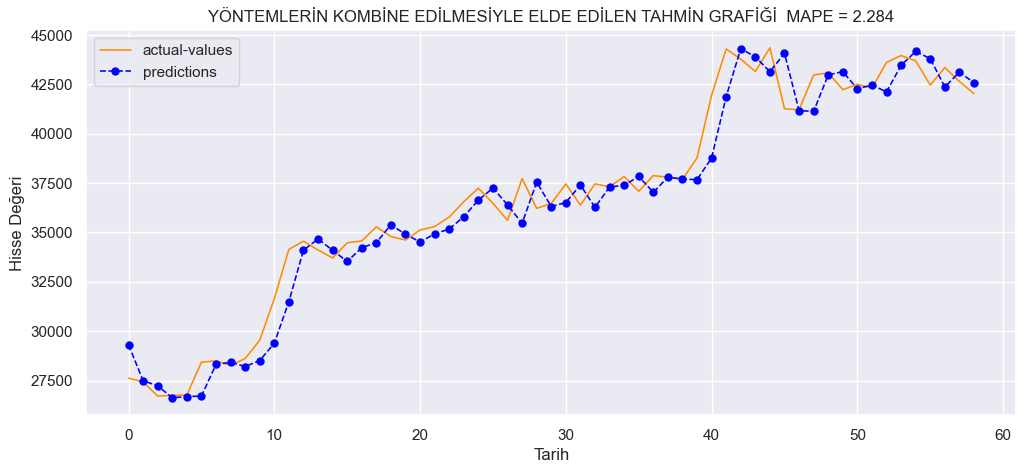

In [60]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(average_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("YÖNTEMLERİN KOMBİNE EDİLMESİYLE ELDE EDİLEN TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(combined_mape,3)))
plt.legend();

#